# Pion GNN Combined (with Hyper Parameter Optimization)

## 0. Initialization

### Set-up the Notebook

In [0]:
#@title Initialize the Python Notebook
import sys, ipywidgets as widgets
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title ### Install external libraries
#@markdown <br> 1. Graph Nets (DeepMind)
#@markdown <br> 2. Tensorflow (GPU)
#@markdown <br> 3. Tensorflow Probability
#@markdown <br> 4. Scikit Optimize
%%capture
EXTERNAL_LIBRARIES = "True" #@param ["True","False"]
if EXTERNAL_LIBRARIES.lower() == "true":
  !pip install tensorflow-gpu
  !pip install graph_nets
  !pip install scikit-optimize
  !pip install -U dm-sonnet==1.23 # v1.23 doesn't have dropout option in snt.nets.MLP
  !pip install tensorflow-probability

### Import Libraries

In [0]:
#@title General Purpose Libraries

import numpy as np
import time, datetime
import re, collections, itertools
import matplotlib.pyplot as plt
import pandas as pd
import random, math
import os, sys
import warnings
import inspect
from os import listdir
from os.path import isfile, join
from array import array

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [0]:
#@title Machine Learning Libraries

from graph_nets import blocks, utils_tf, utils_np, modules, graphs
from graph_nets.demos import models
import sonnet as snt
import tensorflow as tf
import keras
from keras.models import Sequential, clone_model, Model
from keras.optimizers import Adam
from keras.layers import InputLayer, Dense, Dropout, Flatten
from keras import regularizers, optimizers, backend
from keras.callbacks import EarlyStopping, ModelCheckpoint

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Using TensorFlow backend.


In [0]:
#@title Data Manipulation and Analysis Libraries

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm, linregress
from scipy import stats
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
import networkx as nx

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Set Program to Run with GPUs

In [0]:
#@title ### Set to run with GPUs { vertical-output: true }

DEVICE_NAME = tf.test.gpu_device_name()
if DEVICE_NAME != '/device:GPU:0':
  raise SystemError('GPU device not found')

# Choose memory allocation option
MEMORY_ALLOCATION = "Dynamic" #@param ["Dynamic","Fixed"]
#@markdown **Dynamic allocation** increases memory based on need as the program runs
#@markdown <br> **Fixed allocation** maintains the same GPU usage throughout the program 

config = tf.ConfigProto(log_device_placement = True)
if MEMORY_ALLOCATION.lower() == "fixed":
  GPU_FRAC = widgets.FloatSlider(min=0, max=1.0,
                 step=0.05, value=0.5,
                 description="GPU Frac",
                 continuous_update=True)
  display(GPU_FRAC)
else:
  config.gpu_options.allow_growth = True
  print("Using dynamic memory growth on {}".format(DEVICE_NAME))

Using dynamic memory growth on /device:GPU:0


In [0]:
#@title Under the hood settings to start the tensorflow session.

if MEMORY_ALLOCATION.lower() == 'fixed':
  config.gpu_options.per_process_gpu_memory_fraction = GPU_FRAC.value
  print("Using {}% of {}".format(GPU_FRAC.value*100,
                                DEVICE_NAME))
  
SESSION = tf.Session(config=config)

In [0]:
#@title Create a folder to hold the results from this run and indicate where test dataset is contained.

GOOGLE_DRIVE = './drive/My Drive/Colab Notebooks/'

MODEL_DIR = GOOGLE_DRIVE + "GNN model/" + str(datetime.date.today()) + "/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

TAG_NUM = str(datetime.datetime.now().hour)
TAG = datetime.datetime.today().strftime('%m-%d') + ' (' + TAG_NUM +')'

print('Folder name containing the data:')
#FOLDER = input()
FOLDER = 'Pion Test Beam'
print(FOLDER)
DATA_DIR = GOOGLE_DRIVE + "/" + FOLDER

RUNTIME = time.time() # track the total runtime

Folder name containing the data:


## 1. Data Import

In [0]:
#@title Determine the file names within the specified dataset folder

FILES = [f for f in listdir(DATA_DIR) if isfile(join(DATA_DIR, f))] # reads in file names

# Declare the file data dicts
files99 = {} # Barrel ECAL
files33 = {} # Outer HCAL
files34 = {} # Barrel HCAL

print("Using files:")
for FILE in FILES:
  print(FILE)

Using files:
pi-200GeV.txt
pi-300GeV.txt
pi-100GeV.txt
pi-150GeV.txt
pi-9GeV.txt
pi-50GeV.txt
pi-30GeV.txt
pi-20GeV.txt
pi-8GeV.txt
pi-7GeV.txt
pi-6GeV.txt
pi-5GeV.txt
pi-4GeV.txt
pi-3GeV.txt
pi-2GeV.txt


In [0]:
#@title Populate the data dict

for ENERGY in FILES:
    buffer99 = []
    buffer34 = []
    buffer33 = []
    FILE = open(DATA_DIR + '/' + ENERGY) 
    DATA = FILE.readlines() # data is a list containing j lines
    for VALUE in DATA:
        # fromstring turns a sentence (l.strip) into a 1D array
        LINE = np.fromstring(VALUE.strip(),sep = " ") # 1D array
        if len(LINE) == 9:
            buffer99.append(LINE)
        if len(LINE) == 4:
            buffer34.append(LINE)
        if len(LINE) == 3:
            buffer33.append(LINE)
    files99[ENERGY] = buffer99
    files34[ENERGY] = buffer34
    files33[ENERGY] = buffer33

Define some functions for shaping the $9\times9$ and $3\times4$ data into image arrays.

In [0]:
#@title Image Helper Functions

def shapeimages9x9(lines):
    img9x9 = {}
    # keys identifies the dataset 'labels' from 'lines' (i.e. pi-9GeV)
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            # extend adds 'line' to the list 'img'
            img.extend(line)
            if counter%9 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img9x9[key] = imgs
    return img9x9

def shapeimages3x4(lines):
    img3x4 = {}
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            img.extend(line)
            if counter%3 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img3x4[key] = imgs
    return img3x4

In [0]:
#@markdown Apply the helper functions to the 9x9 and 3x4 data.

img_EB = shapeimages9x9(files99)
img_HB = shapeimages3x4(files34)

## 2. Preprocessing
> 1. Define how many samples are to be used during optimization 
> 2. Evenly sample across all datasets according to least number for training
> 3. Splitting the dataset into training and validation sets

In [0]:
#@title Define values used during preprocessing

RATIO = 0.1 # fraction of sample that will be validation data
RNG_SPLIT = np.random.randint(0,100) # choose the seed for deciding how to split the training and validation data
# RNG_SPLIT = 0 # set this for same split
OPT_SAMPLES = 1000 # set this for hyper parameter optimization

In [0]:
#@title Define some containers

x_EB = [] # contains EB data for both training and validation
x_HB = [] # contains HB data for both training and validation
y = [] # contains truth values for training

In [0]:
#@title Determine the minimal number of samples in the energy datasets
samples = [] # array to hold MIN_SAMPLES candidates
for i in img_EB:
    samples.append(np.shape(img_EB[i])[0])
    
MIN_SAMPLES = min(samples)

In [0]:
#@title Sample evenly across all energy datasets to build the train/test set
start_time = time.time()

for i in img_EB:
  num_energy = np.shape(img_EB[i])[0] # entries for a given energy
  perc_smp = np.around((float(OPT_SAMPLES) / num_energy),3)
  print('{}: {} % images used'.format(i, perc_smp*100))
  img_EB_buff = np.array(img_EB[i])
  img_HB_buff = np.array(img_HB[i])
  
  x_EB.extend(img_EB_buff[0:OPT_SAMPLES,:])
  x_HB.extend(img_HB_buff[0:OPT_SAMPLES,:])  

  # associate truth value array with the training and testing sets
  energy = np.int(re.findall(r'\d+',i)[0]) # extracts energy value
  y.extend(np.full(OPT_SAMPLES,energy)) # populates the truth dataset
    
elapsed_time = time.time() - start_time
print('Elapsed time: {} seconds'.format(elapsed_time))
a = np.shape(x_EB)[0]
b = OPT_SAMPLES * np.size(FILES)
print('x_EB and x_HB have {} images; expected {} images.'.format(a,b))

pi-200GeV.txt: 11.1 % images used
pi-300GeV.txt: 3.5999999999999996 % images used
pi-100GeV.txt: 6.9 % images used
pi-150GeV.txt: 9.4 % images used
pi-9GeV.txt: 3.5000000000000004 % images used
pi-50GeV.txt: 7.9 % images used
pi-30GeV.txt: 13.600000000000001 % images used
pi-20GeV.txt: 6.7 % images used
pi-8GeV.txt: 5.1 % images used
pi-7GeV.txt: 2.8000000000000003 % images used
pi-6GeV.txt: 2.5 % images used
pi-5GeV.txt: 2.5 % images used
pi-4GeV.txt: 3.4000000000000004 % images used
pi-3GeV.txt: 4.1000000000000005 % images used
pi-2GeV.txt: 9.6 % images used
Elapsed time: 4.889420747756958 seconds
x_EB and x_HB have 15000 images; expected 15000 images.


In [0]:
#@title Split into Training and Validation sets
#@markdown No test set will be used since comparison to Abdullin et. al.
#@markdown requires using the full dataset (unevenly sampled across energies)


x_train_EB, x_val_EB, x_train_HB, x_val_HB, y_train, y_val = train_test_split(
  x_EB, x_HB, y,
  test_size = RATIO, random_state = RNG_SPLIT)

# reshape the datasets
x_train_EB = np.reshape(x_train_EB,((-1,9,9)))
x_val_EB = np.reshape(x_val_EB,((-1,9,9)))
x_train_HB = np.reshape(x_train_HB,((-1,3,4)))
x_val_HB = np.reshape(x_val_HB,((-1,3,4)))
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

## 3.  Define the GNN and Optimization Space

In [0]:
#@title Variables to *edit* for hyper parameter optimization and training

# Optimization Training parameters
EPOCHS_OPT = 20 # epochs for training each hyper parameter iteration
EPOCHS = 30 # epochs for optimized training

# GNN static parameters
ZERO_SUP_THRESHOLD_EB = -10.0 # if << 0, then zero suppresion is turned off
ZERO_SUP_THRESHOLD_HB = -10.0
SAVE_PERIODIC = False
EPOCH_PERIOD = 1 
LOG_PERIOD = 0
PATIENCE = 3 # number of epochs before early stopping implemented
DELTA = 1e-7 # set this based on the magnitude of the loss function
N_BEST = 1

FULL_GNN = True # set to false if using a simplifed structure

# Optimization parameter space
BATCH_SIZE = [30,80]
NUM_LAYERS = [1,2]
LATENT_SIZE = [30,80]
LEARNING_RATE = [1e-3,1e-2]
LR_BOUNDS = [5,15]
PROCESS_STEPS = [3,10]

# Optimizer parameters
NCALLS = 15
NSTARTS = 10

# Dataset parameters
Y_RANGE_EB, X_RANGE_EB = 7, 7
Y_RANGE_HB, X_RANGE_HB = 3, 3

In [0]:
#@title Define helper functions for building graph network
#@markdown 1. __findCentroidNeighbors__(cal_image,
#@markdown y_range, x_range, img_id)<br>
#@markdown 2. __findNearestNeighbors__(index, image1, image2)<br>
#@markdown 3. __lossOps__(output_list, y)

# selects (y_range, x_range) pixels around the centroid
def findCentroidNeighbors(cal_image, y_range, x_range, img_id):
  y_length = cal_image.shape[0]
  x_length = cal_image.shape[1]
  
  assert(y_range <= y_length)
  assert(x_range <= x_length)
  
  cul_x = 0.0
  cul_y = 0.0
  energy_total = 0.0 # holds the sum of the nearest neighbor energy
  for node_y in range(y_length - 1):
    for node_x in range(x_length - 1):
      pixel = cal_image[node_x, node_y]
      cul_x += (node_x)*pixel
      cul_y += (node_y)*pixel
      energy_total += pixel
      
  if(energy_total > 1e-10):
    (centroid_y, centroid_x) = (cul_y / energy_total, cul_x / energy_total)
  else:
    (centroid_y, centroid_x) = ((y_length - 1)/2.0, (x_length - 1)/2.0)
    
  (centroid_y, centroid_x) = round(centroid_y, 14), round(centroid_x, 14)
  
  (y_begin, y_end) = (int(math.ceil(centroid_y - y_range / 2.0)),
                      int(math.ceil(centroid_y + y_range / 2.0)))
  (x_begin, x_end) = (int(math.ceil(centroid_x - x_range / 2.0)),
                      int(math.ceil(centroid_x + x_range / 2.0)))
  
  if y_begin < 0:
    (y_begin, y_end) = (0, y_range)
  if y_end > y_length:
    (y_begin, y_end) = (y_length - y_range, y_length)
  if x_begin < 0:
    (x_begin, x_end) = (0, x_range)
  if x_end > x_length:
    (x_begin, x_end) = (x_length - x_range, x_length)
  assert(y_end - y_begin == y_range)
  assert(x_end - x_begin == x_range)
  
  return ((y_begin, y_end), 
          (x_begin, x_end),
          (centroid_y, centroid_x))

# method for identifying the indices of nearest neighbors in 2 channels
def findNearestNeighbors(me,image1,image2):
  neighbor_set = []
  assert(me < len(np.concatenate((image1.ravel(),image2.ravel())))),\
  "Index is too large."
  assert(me >= 0),"Index is less than zero."
  if me < len(image1.ravel()):
    x_index = me % np.shape(image1)[0] 
    y_index = me // np.shape(image1)[0]
    if x_index > 0: # left neighbor
      neighbor_set.append(me - 1)
    if x_index < len(img_5x5) - 1: # right neighbor
      neighbor_set.append(me + 1)
    if y_index > 0: # up neighbor
      neighbor_set.append(me - len(image1))
    if y_index < len(img_5x5) - 1: # down neighbor)
      neighbor_set.append(me + len(image1))
  else:
    x_index = (me - len(image1.ravel())) % np.shape(image2)[0]
    y_index = (me - len(image1.ravel())) // np.shape(image2)[0]
    if x_index > 0: # left neighbor
      neighbor_set.append(me - 1)
    if x_index < len(img_3x3) - 1: # right neighbor
      neighbor_set.append(me + 1)
    if y_index > 0: # up neighbor
      neighbor_set.append(me - len(image2))
    if y_index < len(img_3x3) - 1: # down neighbor)
      neighbor_set.append(me + len(image2))
  
  return neighbor_set
  
      
def lossOps(output_list, y):
  if not isinstance(output_list, collections.Sequence):
    output_list = [output_list]
  loss = tf.reduce_mean( tf.square( (y - output_list[-1].globals) / y ) )
  return loss

## 4. Optimize the GNN

In [0]:
#@title Hyper parameter space
#@markdown > 1. Batch Size
#@markdown > 2. Hidden Layers
#@markdown > 3. Latent Size
#@markdown > 4. Process Steps
#@markdown > 5. Learning Rate
#@markdown > 6. Learning Rate Bounds

space = [
    Integer(BATCH_SIZE[0], BATCH_SIZE[1], name = 'batch_size'),
    Integer(NUM_LAYERS[0], NUM_LAYERS[1], name = 'hidden_layers'),
    Integer(LATENT_SIZE[0], LATENT_SIZE[1], name = 'latent_size'),
    Integer(PROCESS_STEPS[0], PROCESS_STEPS[1], name = 'process_steps'),
    Real(LEARNING_RATE[0], LEARNING_RATE[1], 'log-uniform', name = 'learning_rate'),
    Integer(LR_BOUNDS[0], LR_BOUNDS[1], name = 'lr_bounds')
]

In [0]:
#@title Helper Functions for GNN Optimization
#@markdown > __trainModel__(batch_size, hidden_layers,latent_size,
#@markdown process_steps, learning_rate, lr_bounds)
#@markdown >> 1. __makeMLPModel()__: specify DNN architecture here <br>
#@markdown >> 2. __MLPGraphIndependent()__: instance of snt.AbstractModule, for 
#@markdown >> encoding and decoding graphs <br>
#@markdown >> 3. __MLPGraphNetwork()__: instance of snt.AbstractModule, for
#@markdown >> constructing the graph<br>
#@markdown >> 4. __EncodeProcessDecode()__: represents the graph model
#@markdown >> 5. __runTraining()__: updates the model and computes the loss
#@markdown >> 6. __runValidation()__: computes the validation loss
#@markdown >> 7. __createInputFeed()__: populates nodes, edges, senders, 
#@markdown >> receivers and global features to be fed into graph construction
def trainModel(
    batch_size,
    hidden_layers,
    latent_size,
    process_steps,
    learning_rate,
    lr_bounds
):
  def makeMLPModel():
    return snt.Sequential([
      snt.nets.MLP([latent_size] * hidden_layers,
        activate_final = False,
        activation = tf.nn.softplus
        ),
      snt.LayerNorm()
  ])
  
  class MLPGraphIndependent(snt.AbstractModule):
    def __init__(self, name = "MLPGraphIndependent"):
      super(MLPGraphIndependent, self).__init__(name = name)
      with self._enter_variable_scope():
        self._network = modules.GraphIndependent(
          edge_model_fn = makeMLPModel,
          node_model_fn = makeMLPModel,
          global_model_fn = makeMLPModel
        )
      
    def _build(self, inputs):
      return self._network(inputs)
  
  class MLPGraphNetwork(snt.AbstractModule):
    def __init__(self, name = "MLPGraphNetwork"):
      super(MLPGraphNetwork, self).__init__(name = name)
      with self._enter_variable_scope():
        self._network = modules.GraphNetwork(
            edge_model_fn = makeMLPModel,
            node_model_fn = makeMLPModel,
            global_model_fn = makeMLPModel
            )
      
    def _build(self, inputs):
      return self._network(inputs)
  
  class EncodeProcessDecode(snt.AbstractModule):
    def __init__(
        self,
        edge_output_size = None,
        node_output_size = None,
        global_output_size = None,
        name = 'EncodeProcessDecode'):
      super(EncodeProcessDecode, self).__init__(name = name)
      self._encoder = MLPGraphIndependent()
      self._core = MLPGraphNetwork()
      self._decoder = MLPGraphIndependent()
  
      if edge_output_size is None:
        edge_fn = None
      else:
        edge_fn = lambda: snt.Linear(edge_output_size, name = 'edge_output')
      if node_output_size is None:
        node_fn = None
      else:
        node_fn = lambda: snt.Linear(node_output_size, name = 'node_output')
      if global_output_size is None:
        global_fn = None
      else:
        global_fn = lambda: snt.Linear(global_output_size, name= "global_output")
      with self._enter_variable_scope():
        self._output_transform = modules.GraphIndependent(edge_fn, node_fn,
                                                     global_fn)

    def _build(self, input_op, num_processing_steps):
      latent = self._encoder(input_op)
      latent0 = latent
      output_ops = []
      for _ in range(num_processing_steps):
        core_input = utils_tf.concat([latent0, latent], axis = 1)
        latent = self._core(core_input)
    
        decoded_op = self._decoder(latent)
        output_ops.append(self._output_transform(decoded_op))
      return output_ops

  tf.reset_default_graph()
  
  train_size = len(y_train) - len(y_train) % batch_size
  val_size = len(y_val) - len(y_val) % batch_size
  
  num_train_itr = train_size // batch_size
  num_val_itr = val_size // batch_size
  
  valid_loss_avg = 0
  
  EPOCHS_FROM_MIN = 0
  
  EPOCHS_TO_MIN = 1
  
  input_feed_train = {}
  input_feed_valid = {}
  input_graphs_dict = []
  
  train_loss_list = []
  train_epoch_count = []
  valid_loss_list = []
  valid_epoch_count = []
  
  for _ in range(batch_size):
    nodes = [[0.0, 0.0, 0.0, 0]]
    edges = [[0.0]]
    receivers = [0]
    senders = [0]
    globals = [0.0]
    input_graphs_dict.append({
        "nodes":nodes,\
        "edges":edges,\
        "receivers":receivers,\
        "senders":senders,\
        "globals":globals
    })
    
  input_graph_placeholders = utils_tf.placeholders_from_data_dicts(
    input_graphs_dict, force_dynamic_num_graphs = False)
    
  label_placeholders = tf.compat.v1.placeholder(tf.float32,
                                               shape = (batch_size, 1))

  model = EncodeProcessDecode(global_output_size = 1)
  
  output_list = model(input_graph_placeholders,
                      process_steps)
  
  loss_op = lossOps(output_list, label_placeholders)
  
  LR_EPOCH_NUM = tf.Variable(0, trainable = False, dtype = tf.int32)
  LR_BOUNDS = [np.int32(lr_bounds), np.int32(2*lr_bounds)]
  LR_VALUES = [learning_rate, 0.5*learning_rate, 0.25*learning_rate]
  LR = tf.train.piecewise_constant(
    LR_EPOCH_NUM, LR_BOUNDS, LR_VALUES
  )
  
  increment_lr_epoch_num_op = tf.assign(LR_EPOCH_NUM, LR_EPOCH_NUM + 1)
  optimizer = tf.train.AdamOptimizer(LR)
  step_op = optimizer.minimize(loss_op)
  
  saver = tf.compat.v1.train.Saver(max_to_keep = N_BEST)
  
  sess = tf.compat.v1.Session()
  sess.run(tf.global_variables_initializer())

  def createInputFeed(itr, batch_size, EB_X, HB_X, Y, is_train):

    start_idx = itr * batch_size
    end_idx = start_idx + batch_size

    img_dict = []
    for image_idx in range(start_idx, end_idx):

      (y_begin, y_end), (x_begin, x_end), (_, _) = findCentroidNeighbors(
        EB_X[image_idx], Y_RANGE_EB, X_RANGE_EB, image_idx)
      pixels_ecal = np.array(EB_X[image_idx, y_begin: y_end, x_begin: x_end])
      (y_begin, y_end), (x_begin, x_end), (_, _) = findCentroidNeighbors(
        HB_X[image_idx], Y_RANGE_HB, X_RANGE_HB, image_idx)
      pixels_hcal = np.array(HB_X[image_idx, y_begin: y_end, x_begin: x_end])

      nodes, edges, receivers, senders = [], [], [], []
      global_features = [0.0]

      nodes_selected_ecal = pixels_ecal > ZERO_SUP_THRESHOLD_EB
      nodes_selected_hcal = pixels_hcal > ZERO_SUP_THRESHOLD_HB
      assert((np.count_nonzero(nodes_selected_ecal) > 0) or 
            (np.count_nonzero(nodes_selected_hcal) > 0))

      # EB Nodes
      coord_to_node_id_ecal = {}
      for node_y in range(Y_RANGE_EB):
        for node_x in range(X_RANGE_EB):
          if nodes_selected_ecal[node_y, node_x] == True: # threshold check
            node_id = len(nodes) # assign node ID by index value
            coord_to_node_id_ecal[(node_y, node_x)] = node_id # correlate ID to coordinate
            nodes.append([pixels_ecal[node_y, node_x], node_y, node_x, +1]) # populate node list
      # Connect immediate neighbors in EB Nodes
      for (node_y, node_x), this_node_id in coord_to_node_id_ecal.items():
        neighbors_to_check = [(node_y - 1, node_x), (node_y + 1, node_x),
                              (node_y, node_x - 1), (node_y, node_x + 1),
                              (node_y, node_x)]
        for (neighbor_y, neighbor_x) in neighbors_to_check:
          if (neighbor_y, neighbor_x) in coord_to_node_id_ecal:
            edges.append([1.0])
            senders.append(this_node_id)
            receivers.append(coord_to_node_id_ecal[(neighbor_y, neighbor_x)])


      # HB Nodes
      coord_to_node_id_hcal = {}
      for node_y in range(Y_RANGE_HB):
        for node_x in range(X_RANGE_HB):
          if nodes_selected_hcal[node_y, node_x] == True:
            node_id = len(nodes)
            coord_to_node_id_hcal[(node_y, node_x)] = node_id
            nodes.append([pixels_hcal[node_y, node_x], node_y, node_x, -1])

      # Connect immediate neighbors in HB nodes
      for (node_y, node_x), this_node_id in coord_to_node_id_hcal.items():
        neighbors_to_check = [(node_y - 1, node_x), (node_y + 1, node_x),
                            (node_y, node_x - 1), (node_y, node_x + 1),
                            (node_y, node_x)]
        for (neighbor_y, neighbor_x) in neighbors_to_check:
          if (neighbor_y, neighbor_x) in coord_to_node_id_hcal:
            edges.append([1.0])
            senders.append(this_node_id)
            receivers.append(coord_to_node_id_hcal[(neighbor_y, neighbor_x)])


      if FULL_GNN == True:
      # Connect all EB nodes with HB nodes
        ecal_hcal_connections = itertools.product(coord_to_node_id_ecal.values(),
                                               coord_to_node_id_hcal.values())
        for (ecal_node_id, hcal_node_id) in ecal_hcal_connections:
          edges.append([1.0])
          senders.append(ecal_node_id)
          receivers.append(hcal_node_id)
          edges.append([1.0])
          senders.append(hcal_node_id)
          receivers.append(ecal_node_id)
      else: # only connects the centroids of the EB and HB
        EB_SIZE = X_RANGE_EB*Y_RANGE_EB
        HB_SIZE = X_RANGE_HB*Y_RANGE_HB
        edges.append([1.0])
        senders.append(EB_SIZE // 2 + 1) # ID indices start at 1, not 0
        receivers.append(EB_SIZE + HB_SIZE // 2 + 1)
        edges.append([1.0])
        senders.append(EB_SIZE + HB_SIZE // 2 + 1)
        receivers.append(EB_SIZE // 2 + 1)
        
      img_dict.append({
          "nodes": nodes,
          "edges": edges,
          "receivers": receivers,
          "senders": senders,
          "globals": global_features
      })
    input_graphs = utils_np.data_dicts_to_graphs_tuple(img_dict)
    feed_dict = {input_graph_placeholders: input_graphs,
                 label_placeholders: Y[start_idx:end_idx, np.newaxis]}

    return feed_dict

  def runTraining():
    train_loss = []
    num_batch_trained = 0
    for itr in range(num_train_itr):
      input_feed = createInputFeed(
        itr, batch_size, x_train_EB, x_train_HB, y_train, is_train = True)
      train_values = sess.run({
          "step": step_op,
          "loss": loss_op
      }, feed_dict = input_feed)
      train_loss.append(train_values["loss"])
      num_batch_trained += 1
    train_loss_avg = sum(train_loss) / num_batch_trained
    return train_loss_avg

  def runValidation():
    valid_loss = []
    num_batch_eval = 0
    for itr_valid in range(num_val_itr):
      input_feed = createInputFeed(
        itr_valid, batch_size, x_val_EB, x_val_HB, y_val, is_train = False)
      valid_values = sess.run({
        "loss": loss_op
        }, feed_dict = input_feed)
      valid_loss.append(valid_values["loss"])
      num_batch_eval += 1
    valid_loss_avg = sum(valid_loss) / num_batch_eval
    return valid_loss_avg
    
  START_TIME = time.time()
  last_log_time = START_TIME
  
  print("# Epoch,  T (elapsed), Loss train, Loss valid")
  
  for epoch in range(EPOCHS_OPT):
  
    train_loss_avg = runTraining()
    train_loss_list.append(train_loss_avg)
    train_epoch_count.append(epoch + 1)
    sess.run(increment_lr_epoch_num_op)
  
    if SAVE_PERIODIC and (epoch + 1) % EPOCH_PERIOD == 0:
      saver_periodic.save(sess, "./model-%s-Periodic" % (start_time),
                         global_step = epoch + 1)
    
    elapsed_since_last_log = time.time() - last_log_time
    if elapsed_since_last_log > LOG_PERIOD:
      valid_loss_avg = runValidation()
      if epoch == 0: valid_loss_min = valid_loss_avg
      elapsed = ( time.time() - START_TIME) / 60.0
      last_log_time = time.time()
      print("# {:05d},   {:.1f} min,     {:.5f},    {:.5f}".format(
        epoch+1, elapsed, train_loss_avg, valid_loss_avg))
      valid_loss_list.append(valid_loss_avg)
      valid_epoch_count.append(epoch + 1)
      EPOCHS_FROM_MIN += 1
    if (valid_loss_avg < valid_loss_min) and\
      (valid_loss_min - valid_loss_avg) > DELTA : 
      valid_loss_min = valid_loss_avg
      EPOCHS_FROM_MIN = 0
      saver.save(sess,
                MODEL_DIR + "GNN Model " + TAG
                )
      EPOCHS_TO_MIN = epoch + 1
    if EPOCHS_FROM_MIN > PATIENCE: break # early stopping

  print("Training completed in {:.1f} min, best validation loss = {:.5f}".format(
        (time.time() - START_TIME) / 60.0, valid_loss_min))
  
  return (valid_loss_min / EPOCHS_TO_MIN)

@use_named_args(space)
def objective(**X):
  print('New configuration: {}'.format(X))
  
  WEIGHT_LOSS = trainModel(
      batch_size = X['batch_size'],
      hidden_layers = X['hidden_layers'],
      latent_size = X['latent_size'],
      process_steps = X['process_steps'],
      learning_rate = X['learning_rate'],
      lr_bounds = X['lr_bounds']
  )
  
  print('Best weighted validation loss: {}'.format(WEIGHT_LOSS))
  print('\n')
  return WEIGHT_LOSS

In [0]:
#@title Run the optimization

backend.clear_session()
START_TIME = time.time()
res_gp = gp_minimize(func = objective,
                    dimensions = space,
                    n_calls = NCALLS,
                    n_random_starts = NSTARTS,
                    verbose = True)
print('Finished optimization in: {} s'.format(time.time() - START_TIME))

Iteration No: 1 started. Evaluating function at random point.
New configuration: {'batch_size': 68, 'hidden_layers': 1, 'latent_size': 47, 'process_steps': 5, 'learning_rate': 0.0034465296317295717, 'lr_bounds': 6}
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
# Epoch,  T (elapsed), Loss train, Loss valid
# 00001,   1.7 min,     0.50371,    0.43363
# 00002,   3.4 min,     0.39080,    0.32314
# 00003,   5.0 min,     0.32977,    0.27671
# 00004,   6.7 min,     0.26189,    0.23069
# 00005,   8.4 min,     0.22404,    0.19481
# 00006,   10.0 min,     0.19388,    0.17373
# 00007,   11.7 min,     0.17581,    0.17358
# 00008,   13.3 min,     0.15236,    0.15265
# 00009,   14.9 min,     0.13536,    0.13335
# 00010, 

### Visualize the hyper parameter optimization process

Best parameters:   
 Batch Size = 37   
 Hidden Layers = 2   
 Latent Size = 55   
 Process Steps = 4   
 Learning Rate = 0.0015000513368269182   
 Learning Rate Bound = 8


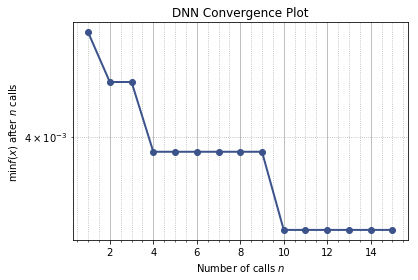

In [0]:
#@title Plot the Convergence
x_list = [
    'Batch Size',
    'Hidden Layers',
    'Latent Size',
    'Process Steps',
    'Learning Rate',
    'Learning Rate Bounds'
]

plt.close()
plot_convergence(res_gp, size = 10)
plt.yscale('log')
plt.title('DNN Convergence Plot')
plt.minorticks_on()
plt.grid(b = 'True', which = 'minor', linestyle = ':')

print('Best parameters: \
  \n Batch Size = {} \
  \n Hidden Layers = {} \
  \n Latent Size = {} \
  \n Process Steps = {} \
  \n Learning Rate = {} \
  \n Learning Rate Bound = {}'.format(res_gp.x[0], res_gp.x[1], res_gp.x[2],
                                     res_gp.x[3], res_gp.x[4], res_gp.x[5])
)

plt.savefig(MODEL_DIR + "GNN Convergence " + TAG + ".png")

plt.show()

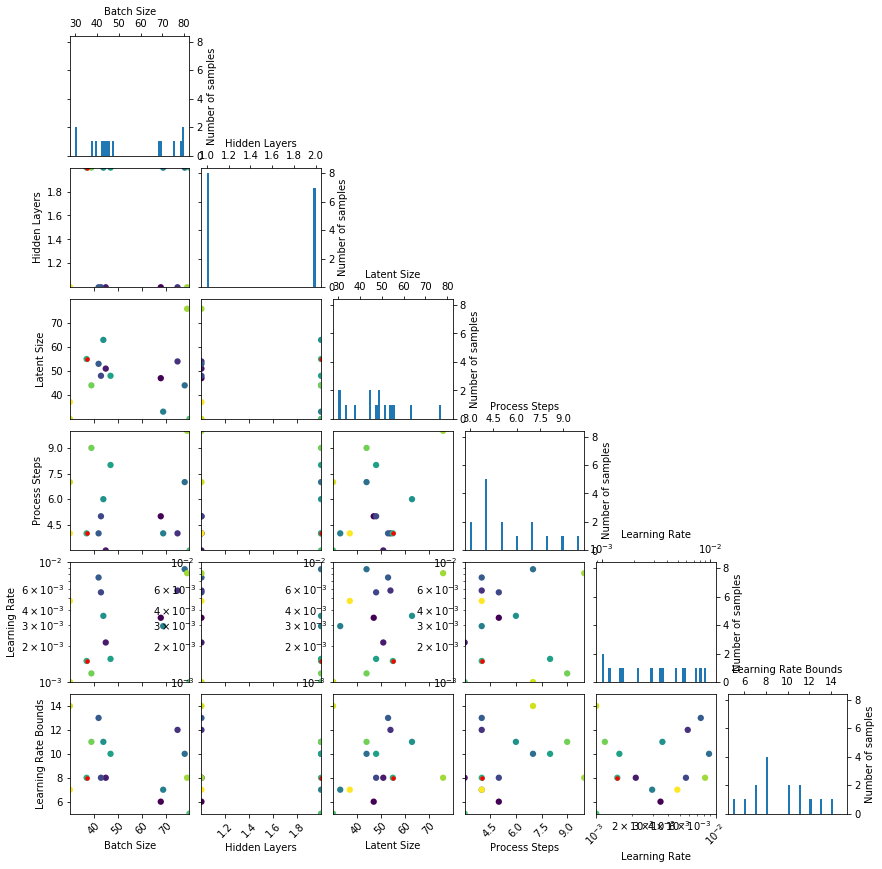

In [0]:
#@title Plot the Sampling Frequency
plt.close()
plot_evaluations(res_gp, bins = 50, dimensions = x_list)
plt.savefig(MODEL_DIR + "GNN Sampling Frequency " + TAG + ".png")
plt.show()

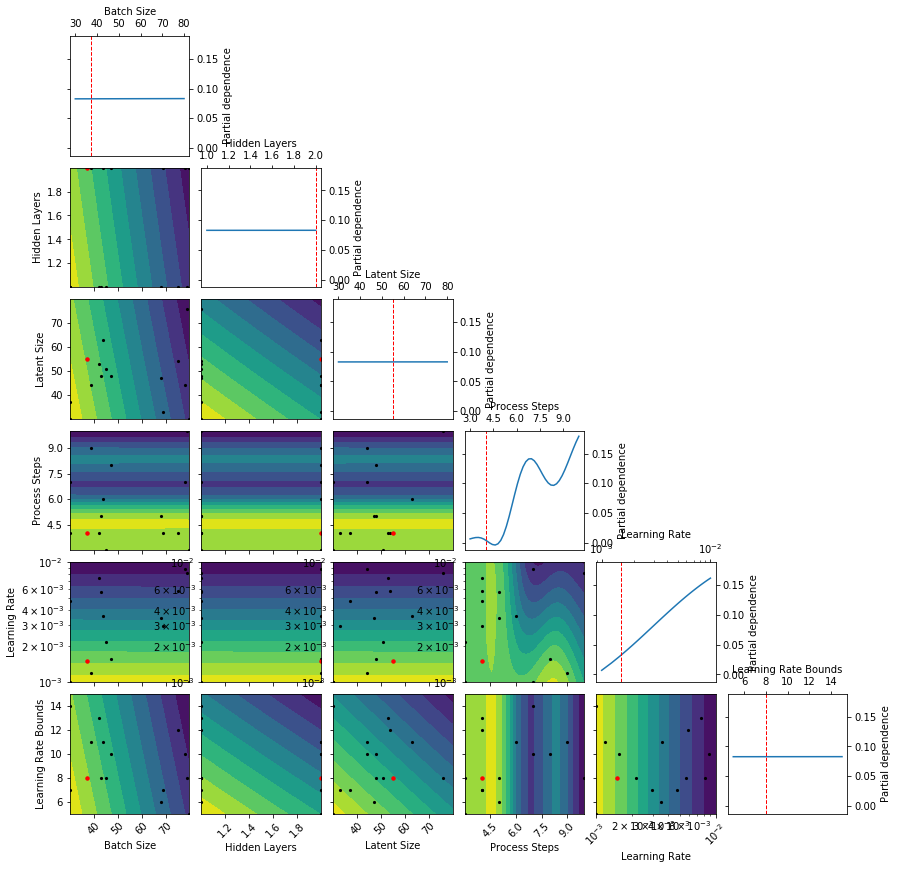

In [0]:
#@title Plot the Hyper Parameter Partial Dependence
plt.close()
plot_objective(res_gp, size = 2, dimensions = x_list)
plt.show()

In [0]:
#@title Save the results from optimization
batch_size = res_gp.x[0]
hidden_layers = res_gp.x[1]
latent_size = res_gp.x[2]
process_steps = res_gp.x[3]
learning_rate = res_gp.x[4]
lr_bounds = res_gp.x[5]

#@title Save a .csv of the optimized hyper parameters
param_file = open(MODEL_DIR + "GNN Log File " + TAG + ".txt", "w")
param_file.write("GNN Parameters \n")
param_file.write("\n---------------------------------")
param_file.write("\nOptimized Parameters:")
param_file.write("\n Batch Size: {}".format(batch_size))
param_file.write("\n Hidden Layers: {}".format(hidden_layers))
param_file.write("\n Latent Size: {}".format(latent_size))
param_file.write("\n Process Steps: {}".format(process_steps))
param_file.write("\n Learning Rate: {}".format(learning_rate))
param_file.write("\n Learning Rate Bounds: {}".format(lr_bounds))
param_file.close()

Running training with optimized hyper parameters: 
 Batch Size = 37 
 Hidden Layers = 2 
 Latent Size = 55 
 Process Steps = 4 
 Learning Rate = 0.0015000513368269182 
 Learning Rate Bounds = 8
